## Combine 700hPa wind files between ERA5 and MPAS, ultimate goal to create one large CV file for tracking

In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd


In [5]:
case_in = 'HELENE'
run_in = 'FOR_KELLY'
year_in = '2006'
cut_start = '2006-09-08-12' #The start of the data to be plotted and considered
cut_end = '2006-09-13-18' #The end of the data to be plotted and considered
cut_start_early = '2006-09-08-09' #09-14-18 default
era5_start = '2006-09-01-00' #06-01-00 default

out_name = 'wind_for_tracking_full'
hr_delta = 1 #Time delta of the MPAS output (hours)
hr_plot_delta = 6 #Time delta of DESIRED output (hours)

In [6]:
mpas_in = '/glade/scratch/qlawton/mpas_runs/HELENE/FOR_KELLY/latlon.nc'
era5_in = '/glade/u/home/qlawton/DATA/AEW_Tracks/wind_season_lowres_700_'+year_in+'_B1-6hr.nc'
mpas_orig = '/glade/scratch/knocasio/3km_MPAS_ERA5_8sept_12utc_limited_area_3/diag.2006-09-08_13.00.00.nc'

out_file = '/glade/u/home/qlawton/scratch/mpas_runs/'+case_in+'/'+run_in+'/'+out_name+'.nc'

In [7]:
mpas_xr = xr.open_dataset(mpas_in, chunks = 'auto')
era5_xr = xr.open_dataset(era5_in, chunks = 'auto').sel(time = slice(era5_start, cut_start_early))

orig_xr = xr.open_dataset(mpas_orig)
u_iso_levels_real = orig_xr['u_iso_levels']

## Start adjusting the mpas data
mpas_xr.coords['u_iso_levels'] = u_iso_levels_real.values
mpas_xr = mpas_xr.sel(u_iso_levels = 700*100)

## Next, we want to round the coordinates and rename the variables in the MPAS files
lat_round = np.round(mpas_xr.coords['latitude'].values)
lon_round = np.round(mpas_xr.coords['longitude'].values)

# Replace with the real value
mpas_xr.coords['longitude'] = lon_round
mpas_xr.coords['latitude'] = lat_round 

# Rename the variables
mpas_xr = mpas_xr.rename({'umeridional_700hPa':'v', 'uzonal_700hPa':'u'})
mpas_xr = mpas_xr.rename_dims({'Time':'time'})

#For later slicing
lat_min_mpas = mpas_xr.latitude.values[0]
lat_max_mpas = mpas_xr.latitude.values[-1]
lon_min_mpas = mpas_xr.longitude.values[0]
lon_max_mpas = mpas_xr.longitude.values[-1]

lat_min = era5_xr.latitude.values[-1]
lat_max = era5_xr.latitude.values[0]
lon_min = era5_xr.longitude.values[0]
lon_max = era5_xr.longitude.values[-1]

#Flip and cut down the era5 data
era5_xr = era5_xr.reindex(latitude=era5_xr.latitude[::-1]).sel(latitude = slice(lat_min_mpas, lat_max_mpas),
                                                              longitude = slice(lon_min_mpas, lon_max_mpas))

#Finally, cut down the longitude of the era5_data
mpas_xr = mpas_xr.sel(longitude = slice(lon_min, lon_max), latitude = slice(lat_min, lat_max))

In [8]:
##### --- TIME FOR MPAS ----- #####
### We also want to make a list of times to represented the start and end dates contained in the files
cut_start_dt = datetime.strptime(cut_start, '%Y-%m-%d-%H')
cut_end_dt = datetime.strptime(cut_end, '%Y-%m-%d-%H')
length_dt = int((cut_end_dt - cut_start_dt).total_seconds()/3600/hr_delta)+1 #Not sure about the plus one here....
timedelta_out = timedelta(hours=hr_delta)

date_list_dt = [cut_start_dt + timedelta_out*hour for hour in range(length_dt)]

date_list = [datetime.strftime(in_dt, '%Y-%m-%d-%H') for in_dt in date_list_dt]
date_list_6hr = date_list[::6]
date_list_dt_6hr = date_list_dt[::6]

### Now put it in the data and cut it down
mpas_xr.coords['time'] = date_list_dt
mpas_xr = mpas_xr.sel(time = date_list_dt_6hr)

In [9]:
##### --- MERGE THE TWO ARRAYS AND SAVE --- #####
merged = xr.concat([era5_xr, mpas_xr], dim = 'time')
merged_test = merged.reindex(latitude=merged.latitude[::-1])

In [12]:
merged.to_netcdf(out_file)
#date_list_dt_6hr

## Test Comparision Plot

In [10]:
avg_mer = merged['v'].sel(latitude = slice(5, 15)).mean(dim = 'latitude')
avg_era5 = era5_xr['v'].sel(latitude = slice(5, 15)).mean(dim = 'latitude')
avg_mpas = mpas_xr['v'].sel(latitude = slice(5, 15)).mean(dim = 'latitude')

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')


Text(1.0, 1.0, 'MPAS Only')

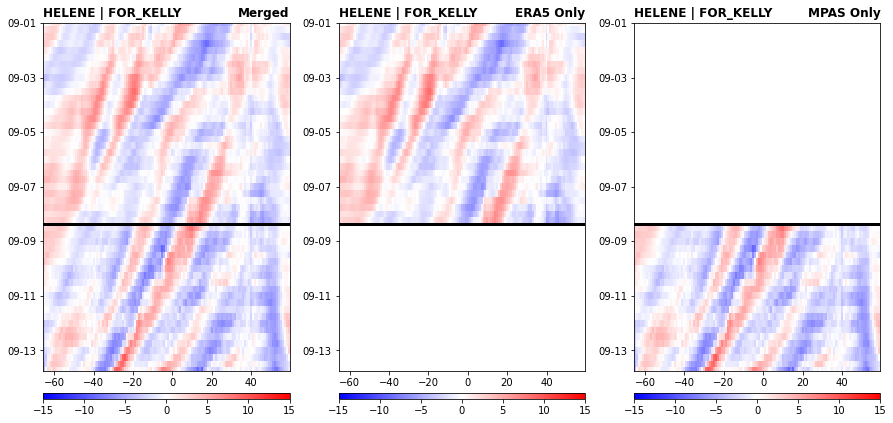

In [11]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(131)
vmin = -15
vmax = 15
d1 = ax.pcolormesh(avg_mer.longitude, pd.to_datetime(avg_mer.time.values), avg_mer, vmin = vmin, vmax = vmax, cmap = 'bwr')
ax.set_ylim([era5_start, cut_end])
ax.axhline(y = cut_start_early, color ='k', linewidth = 3)
plt.gca().invert_yaxis()
cbar1 = plt.colorbar(d1, orientation = 'horizontal', aspect = 40, pad = 0.05)
ax.yaxis.set_major_formatter(myFmt)
ax.set_title(case_in+' | '+run_in, fontsize = 12, fontweight = 'bold', loc = 'left')
ax.set_title('Merged', fontsize = 12, fontweight = 'bold', loc = 'right')

ax2 = fig.add_subplot(132)
d2 = ax2.pcolormesh(avg_era5.longitude, pd.to_datetime(avg_era5.time.values), avg_era5, vmin = vmin, vmax = vmax, cmap = 'bwr')
ax2.set_ylim([era5_start, cut_end])
ax2.axhline(y = cut_start_early, color ='k', linewidth = 3)
plt.gca().invert_yaxis()
cbar2 = plt.colorbar(d2, orientation = 'horizontal', aspect = 40, pad = 0.05)
ax2.yaxis.set_major_formatter(myFmt)
ax2.set_title(case_in+' | '+run_in, fontsize = 12, fontweight = 'bold', loc = 'left')
ax2.set_title('ERA5 Only', fontsize = 12, fontweight = 'bold', loc = 'right')

ax3 = fig.add_subplot(133)
d3 = ax3.pcolormesh(avg_mpas.longitude, pd.to_datetime(avg_mpas.time.values), avg_mpas, vmin = vmin, vmax = vmax, cmap = 'bwr')
ax3.set_ylim([era5_start, cut_end])
ax3.axhline(y = cut_start_early, color ='k', linewidth = 3)
plt.gca().invert_yaxis()
cbar3 = plt.colorbar(d3, orientation = 'horizontal', aspect = 40, pad = 0.05)
ax3.yaxis.set_major_formatter(myFmt)
ax3.set_title(case_in+' | '+run_in, fontsize = 12, fontweight = 'bold', loc = 'left')
ax3.set_title('MPAS Only', fontsize = 12, fontweight = 'bold', loc = 'right')



In [129]:
merged_test = merged.reindex(latitude=merged.latitude[::-1])

In [119]:
merged_test

<xarray.Dataset>
Dimensions:       (latitude: 71, longitude: 125, time: 40)
Coordinates:
  * latitude      (latitude) float32 50.0 49.0 48.0 47.0 ... -18.0 -19.0 -20.0
    u_iso_levels  float32 7e+04
  * longitude     (longitude) float32 -65.0 -64.0 -63.0 -62.0 ... 57.0 58.0 59.0
  * time          (time) datetime64[ns] 2006-09-01 ... 2006-09-10T18:00:00
Data variables:
    u             (time, latitude, longitude) float32 dask.array<chunksize=(30, 71, 125), meta=np.ndarray>
    v             (time, latitude, longitude) float32 dask.array<chunksize=(30, 71, 125), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-21 02:06:57 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...